In [ ]:
import os

os.chdir('/home/jinho93/test/ml/lao')

In [ ]:
from pymatgen import Structure
from monty.serialization import loadfn

data = loadfn('data.json')
train_structures = [d['structure'] for d in data]
train_energies = [d['outputs']['energy'] for d in data]
train_forces = [d['outputs']['forces'] for d in data]

In [40]:
import numpy as np
from maml.utils import pool_from, convert_docs

train_pool = pool_from(train_structures, train_energies, train_forces)
_, df = convert_docs(train_pool)

weights = np.ones(len(df['dtype']), )

# set the weights for energy equal to 100
weights[df['dtype'] == 'energy'] = 1
weights[df['dtype'] == 'force'] = 10000

from maml.base import SKLModel
from maml.describers import BispectrumCoefficients
from sklearn.linear_model import LinearRegression
from maml.apps.pes import SNAPotential

element_profile = {'La': {'r': 6.0, 'w': 1.2},'Al': {'r': 6.0, 'w': 1.1}, 'O': {'r': 6.0, 'w': 1}}
describer = BispectrumCoefficients(rcutfac=0.5, twojmax=8, element_profile=element_profile, 
                                   quadratic=False, pot_fit=True)
model = SKLModel(describer=describer, model=LinearRegression())
snap = SNAPotential(model=model)
snap.train(train_structures, train_energies, train_forces, sample_weight=weights)

INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial
/home/jinho93/miniconda3/envs/mlph/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
from maml.apps.pes import NNPotential
nnp = NNPotential()
nnp.train(train_structures=train_structures,
          train_energies=train_energies,
          train_forces=train_forces,
          cutoff_type=1, atom_energy={'O': -4.14},
        #   cutoff_type=1, atom_energy={'La':-3.14, 'Al': -4.14, 'O': -5.14},
          r_etas = [0.5, 1.0, 2.0],
          # a_etas = [0.5, 2.0],
          r_shift=[0.0],
          # zetas=[1.0, 4.0],
          epochs = 30, r_cut=5, hidden_layers=[4, 4, 4])

In [36]:
from maml.apps.pes import EnergyForceStress
from pymatgen import Structure

os.chdir('/home/jinho93/test/ml/lao/444')

sets_of_forces = []
# efs_calculator = EnergyForceStress(ff_settings=nnp)
# efs_calculator.set_lmp_exe('/home/jinho93/Downloads/n2p2/bin/lmp_mpi')


efs_calculator = EnergyForceStress(ff_settings=snap)
efs_calculator.set_lmp_exe('/home/jinho93/Downloads/lammps-stable_29Sep2021_update2/src/lmp_intel_cpu_intelmpi')

for i in range(1, 4):
    print(i, end = '')
    struct = Structure.from_file(f'POSCAR-0{i:02d}')
    energy, forces, stresses = efs_calculator.calculate([struct])[0]
    sets_of_forces.append(forces)


INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial


123

In [37]:
from phonopy import Phonopy
import numpy as np

from phonopy.interface.calculator import read_crystal_structure
unitcell, _ = read_crystal_structure("POSCAR", interface_mode='vasp')

phonon = Phonopy(unitcell,
                np.identity(3) * 6,
                #  primitive_matrix=np.reshape('0.0 0.5 0.5  0.5 0.0 0.5  0.5 0.5 0.0'.split(), (3, 3)))
                  primitive_matrix=np.identity(3))

In [38]:
phonon.generate_displacements(distance=0.01)

phonon.set_forces(sets_of_forces)

phonon.produce_force_constants()

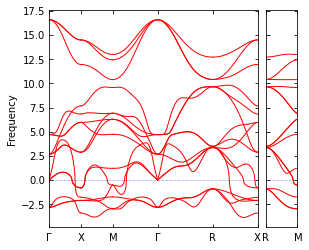

In [39]:
from phonopy.phonon.band_structure import get_band_qpoints
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
#labels = ["$\\Gamma$", "X", "M", "M", "$\\Gamma$", "R", "M"]
# qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
# phonon.run_band_structure(qpoints, path_connections=connections, labels=labels, with_eigenvectors=True)

phonon.auto_band_structure(plot=True, with_eigenvectors=True).show()

In [ ]:
unitcell.get_chemical_symbols()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sets_of_forces[0][:216,0].reshape(6, -1))

In [33]:
efs_calculator = EnergyForceStress(ff_settings=snap)
# efs_calculator.set_lmp_exe('/home/jinho93/Downloads/ls /bin/lmp_mpi')
efs_calculator.set_lmp_exe('/home/jinho93/Downloads/lammps-stable_29Sep2021_update2/src/lmp_intel_cpu_intelmpi')
output = efs_calculator.calculate(train_structures)



INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial


-1082.38897861168 -1081.74930362
-1075.7253848128 -1075.42197668
-1075.547749497 -1075.44217765
-1073.90769645572 -1074.14153415
-1068.03706524149 -1068.41070664
-1063.68243765086 -1063.720113
-1061.48872388154 -1061.266706
-1062.37866685539 -1062.56383569
-1065.04046194255 -1065.23428051
-1069.6172638014 -1069.77177459
-1071.84339565039 -1071.96888217
-1075.09380665421 -1075.11905026
-1076.69879931211 -1076.58199319
-1076.64293285832 -1076.4852424
-1076.81329590827 -1076.69761522
-1074.47902394831 -1074.35876927
-1073.13411333412 -1073.30242084
-1070.73310441524 -1071.03313436
-1068.06006898358 -1068.06223858
-1067.41943845525 -1067.44672018


In [34]:
for i, j in zip(output, train_forces):
    print(i[1][0], j[0])

[1.99840e-15 1.71738e-15 1.42941e-15] [-0.00295903, -0.00325139, -0.00341456]
[ 0.609295 -0.422173 -0.901158] [0.73074143, -0.45333841, -0.91699257]
[-0.682865  0.446688 -0.244037] [-0.50320817, 0.44904466, -0.33952219]
[-0.715487  0.927633  0.332297] [-0.68170241, 0.9234225, 0.36520788]
[0.409755   0.00823504 0.491792  ] [0.41719546, 0.0444091, 0.26885452]
[ 0.697553 -0.333485  0.245139] [0.61590972, -0.23413919, 0.03640243]
[ 1.75671  -0.631883 -0.526132] [1.57437396, -0.58719532, -0.26923049]
[-0.236261 -0.727235 -1.08742 ] [-0.06291633, -0.57624021, -0.96097004]
[-0.90219  -0.704144  0.455586] [-0.79555694, -0.65507438, 0.42495408]
[-1.14865    -0.00134488  0.558317  ] [-1.08446588, -0.00112482, 0.55605471]
[-0.415287  0.285314  0.130829] [-0.46559601, 0.18131907, 0.20615844]
[-0.339521 -0.11039   0.347491] [-0.45853982, -0.1267735, 0.39639228]
[ 1.06334  -0.935904 -0.338296] [0.98061925, -0.89141637, -0.288769]
[ 1.488     0.393037 -0.687556] [1.56679257, 0.46422761, -0.64785309]
